# Les imports (toujours)

In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, UpSampling2D, InputLayer
from skimage.color import rgb2lab, lab2rgb
from IPython.display import display

Using TensorFlow backend.


# Importation du Dataset (à chaque nouvelle Session)

### Dataset 1

In [0]:
#On importe le dataset

!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!tar -xf lfw.tgz
!rm lfw.tgz
!mkdir images
for personne in os.listdir('lfw'):
  for image in os.listdir('lfw/' + personne):
    os.rename('lfw/' + personne + '/' + image, 'images/' + image)
!rm -r lfw

### Dataset 2

In [0]:
!git clone https://github.com/Kernev/Elmer-datasets.git lfw
!mv lfw/lfw images
!rm -r lfw

# Formation des entrees/sorties

In [0]:
#On charge les images en PIL dans sorties

images = os.listdir('images')[:10]
sorties = [load_img('images/' + image) for image in images]

### Version RGB

In [0]:
#On met en entrees les sorties convertis en noir et blanc
entrees = [image.convert('L') for image in sorties]

#On convertit les images en tableaux et on renormalise
sorties = [img_to_array(image).reshape((1, 250, 250, 3))/255 for image in sorties]
entrees = [img_to_array(image).reshape((1, 250, 250, 1))/255 for image in entrees]

### Version LAB

In [0]:
#On transforme en LAB
sorties = [rgb2lab(img_to_array(image) / 255) for image in sorties]

#On isole les teintes de gris pour entrees
#et les teintes de couleurs pour sorties
entrees = [image[:, :, 0] for image in sorties]
sorties = [image[:, :, 1:] for image in sorties]

#On reshape et on renormalise
entrees = [image.reshape(image.shape + (1,))/128 for image in entrees]
sorties = [image/128 for image in sorties]

#On convertit en np array
entrees = np.array(entrees)
sorties = np.array(sorties)

# Modèle

## Construction

In [4]:
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     80        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    9248      
__________

## Parametrisation

In [0]:
model.compile(optimizer='rmsprop', loss='mse')

## Entrainement

### Sur tout le Dataset

#### Useless generator

In [0]:
def generator(x, y, epochs, batch_size):
  for p in range(epochs):
    for i in range(0, len(x), batch_size):
      j = i + batch_size
      yield (x[i:j], y[i:j])

#### Vrai generator

In [0]:
batch_size = 1

datagen = ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
  rotation_range=20,
  horizontal_flip=True)

#### Entrainement

In [7]:
model.fit_generator(datagen.flow(entrees, sorties, batch_size=batch_size),
                    epochs=1000, verbose = 0,
                    steps_per_epoch=len(entrees)/batch_size)

### Sur une seule image

In [0]:
ind = 99
model.fit(x=entrees[ind:ind+1], y=sorties[ind:ind+1], batch_size=1,
          epochs=10000, verbose=0)

# Testation

### Version RGB

In [0]:
SEL = 88

prediction = model.predict(entrees[SEL], batch_size=1).reshape((250,250,3)) * 255
display(array_to_img(prediction))
display(array_to_img(entrees[SEL].reshape(250,250,1)))
display(array_to_img(sorties[SEL].reshape(250,250,3)))

### Version LAB

In [0]:
def prediction_a_img(prediction, entree):
  teintes = prediction.reshape(prediction.shape[1:])
  total = np.append(entree, teintes, axis=2) * 128
  return array_to_img(lab2rgb(total))

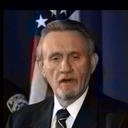

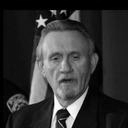

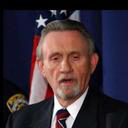

In [9]:
SEL = 1

prediction = model.predict(entrees[SEL:SEL+1], batch_size=1)
display(prediction_a_img(prediction, entrees[SEL]))
display(load_img('images/' + images[SEL], grayscale=True))
display(load_img('images/' + images[SEL]))